In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import gpytorch

import matplotlib.pyplot as plt
from figurefirst import mpl_functions
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import odor_stat_calculations as osc

import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.gaussian_process.kernels import Matern
from sklearn.metrics import accuracy_score, classification_report
from concurrent.futures import ProcessPoolExecutor


from joblib import load, dump

### Gaussian Processes

In [9]:
kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-3, 1e2))

def train_gp_for_file(file_path):
    # Load the data
    df = pd.read_hdf(file_path)
    if 'odor_binary' not in df.columns:
        df['odor_binary'] = df['odor'].apply(lambda x: 10 if x > 0 else 0)
    
    # Subsample the data for faster training 
    data_subsample = df.sample(frac=0.9)
    X = data_subsample[['distance_along_streakline', 'nearest_from_streakline']].values
    y = data_subsample['odor_binary'].values  
    
    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()
    
    # Scale the features
    X_scaled = scaler.fit_transform(X)
    
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3, alpha=0.1)
    gp.fit(X_scaled, y)
    
    return gp, scaler, file_path

folder_path = "/home/beast/An/data/Sept13Plumes/plume1/train/"
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

trained_models = {}
scalers = {}

num_cores = 50
with ProcessPoolExecutor(max_workers=num_cores) as executor:
    results = executor.map(train_gp_for_file, all_files)
    
    for gp_model, scaler, file_path in results:
        trained_models[file_path] = gp_model
        scalers[file_path] = scaler
        # print(f"Completed training for file: {file_path}")
print("Done")

/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_proce

Done


In [18]:
# Save the trained model to a file
# dump(trained_models, '../assets/models/gp_model_90_partialdata_ensemblekernel_2023Nov2.joblib')


# Load the trained_models dictionary from the file
# trained_models = load('../assets/models/gp_model_90_partialdata_2023Nov1.joblib')

['../assets/models/gp_model_90_partialdata_ensemblekernel_2023Nov2.joblib']

### Predict the odor values for the seen data

Accuracy: 0.985
Classification report:               precision    recall  f1-score   support

           0       1.00      0.98      0.99       719
          10       0.96      0.99      0.97       281

    accuracy                           0.98      1000
   macro avg       0.98      0.99      0.98      1000
weighted avg       0.99      0.98      0.99      1000



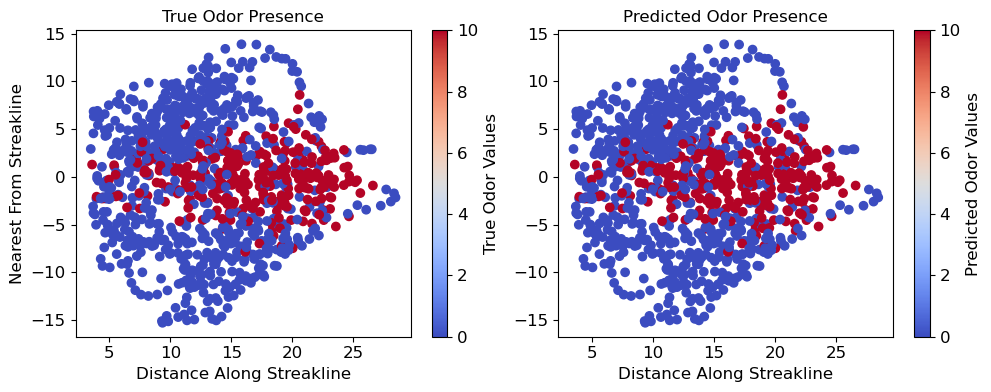

In [21]:
# Testing phase
test_file_path = "/home/beast/An/data/Sept13Plumes/plume1/train/diag29.h5"
test_df = pd.read_hdf(test_file_path)

gp = trained_models[test_file_path]

if 'odor_binary' not in test_df.columns:
    test_df['odor_binary'] = test_df['odor'].apply(lambda x: 10 if x > 0 else 0)

X_test = test_df[['distance_along_streakline', 'nearest_from_streakline']].values
y_true = test_df['odor_binary'].values

# Make predictions using the retrieved GP model
y_pred_mean, y_pred_std = gp.predict(X_test, return_std=True)
y_pred_binary = np.where(y_pred_mean > 3, 10, 0)

accuracy = accuracy_score(y_true, y_pred_binary)
report = classification_report(y_true, y_pred_binary)
print(f"Accuracy: {accuracy}")
print(f"Classification report: {report}")

f, axes = plt.subplots(1,2, figsize=(10, 4))

sc1 = axes[0].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=test_df['odor_binary'], cmap='coolwarm')
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('True Odor Values')
axes[0].set_title('True Odor Presence')
axes[0].set_xlabel('Distance Along Streakline')
axes[0].set_ylabel('Nearest From Streakline')


sc2 = axes[1].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=y_pred_binary, cmap='coolwarm')
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Predicted Odor Values')
axes[1].set_title('Predicted Odor Presence')
axes[1].set_xlabel('Distance Along Streakline')
# axes[1].set_ylabel('Nearest From Streakline')

f.tight_layout()

mpl_functions.set_fontsize(f, 12)

### Prediction on a new data point with new plume

Accuracy: 0.8246153846153846
Classification report:               precision    recall  f1-score   support

           0       0.88      0.86      0.87       859
          10       0.73      0.76      0.75       441

    accuracy                           0.82      1300
   macro avg       0.80      0.81      0.81      1300
weighted avg       0.83      0.82      0.83      1300



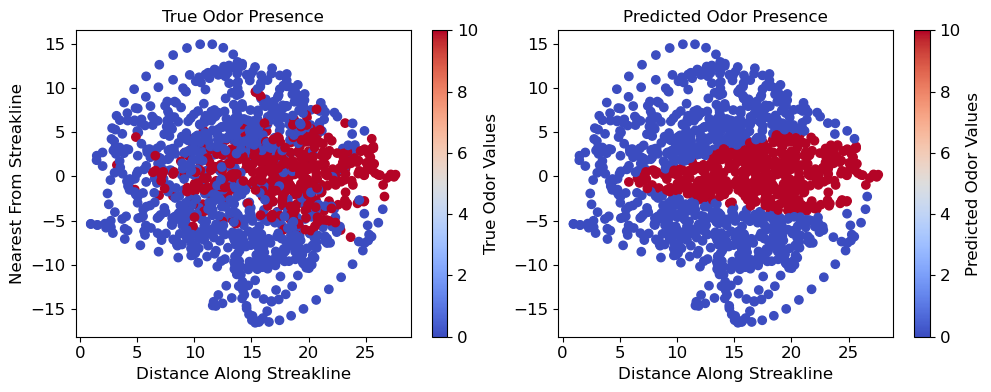

In [23]:
# Choose a representative trained model
representative_file_path = "/home/beast/An/data/Sept13Plumes/plume1/train/diag15.h5"  # Modify this to an actual training file path
gp_representative = trained_models[representative_file_path]

# Path to the new test file
test_file_path = "/home/beast/An/data/Sept13Plumes/plume1/diag1.h5"
test_df = pd.read_hdf(test_file_path)

if 'odor_binary' not in test_df.columns:
    test_df['odor_binary'] = test_df['odor'].apply(lambda x: 10 if x > 0 else 0)

X_test = test_df[['distance_along_streakline', 'nearest_from_streakline']].values
y_true = test_df['odor_binary'].values


y_pred_mean, y_pred_std = gp_representative.predict(X_test, return_std=True)
y_pred_binary = np.where(y_pred_mean > 4.5, 10, 0)

accuracy = accuracy_score(y_true, y_pred_binary)
report = classification_report(y_true, y_pred_binary)
print(f"Accuracy: {accuracy}")
print(f"Classification report: {report}")

f, axes = plt.subplots(1, 2, figsize=(10, 4))


sc1 = axes[0].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=test_df['odor_binary'], cmap='coolwarm')
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('True Odor Values')
axes[0].set_title('True Odor Presence')
axes[0].set_xlabel('Distance Along Streakline')
axes[0].set_ylabel('Nearest From Streakline')


sc2 = axes[1].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=y_pred_binary, cmap='coolwarm')
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Predicted Odor Values')
axes[1].set_title('Predicted Odor Presence')
axes[1].set_xlabel('Distance Along Streakline')

f.tight_layout()

mpl_functions.set_fontsize(f, 12)

#### Using a average representation of the system ( not great )

In [17]:
# test_file_path = "/home/beast/An/data/Sept13Plumes/plume1/diag1.h5"
# test_df = pd.read_hdf(test_file_path)

# if 'odor_binary' not in test_df.columns:
#     test_df['odor_binary'] = test_df['odor'].apply(lambda x: 10 if x > 0 else 0)

# X_test = test_df[['distance_along_streakline', 'nearest_from_streakline']].values
# y_true = test_df['odor_binary'].values

# # Collect predictions from all trained models
# all_predictions = []

# for gp_model in trained_models.values():
#     y_pred_mean, _ = gp_model.predict(X_test, return_std=True)
#     y_pred_binary = np.where(y_pred_mean > 0, 10, 0)
#     all_predictions.append(y_pred_binary)

# # Average the predictions (or take a majority vote)
# # Here we're using the mean; you can also use other aggregation methods
# final_prediction = np.mean(all_predictions, axis=0)
# final_prediction_binary = np.where(final_prediction > 0, 10, 0)

# accuracy = accuracy_score(y_true, final_prediction_binary)
# print(f"Accuracy using all trained models: {accuracy}")


# f, axes = plt.subplots(1, 2, figsize=(10, 4))

# mask = test_df['odor_binary'] >= 0
# sc1 = axes[0].scatter(test_df['distance_along_streakline'][mask], test_df['nearest_from_streakline'][mask], 
#                       c=test_df['odor_binary'][mask], cmap='Blues')
# cbar1 = plt.colorbar(sc1, ax=axes[0])
# cbar1.set_label('True Odor Values')
# axes[0].set_title('True Odor Presence')
# axes[0].set_xlabel('Distance Along Streakline')
# axes[0].set_ylabel('Nearest From Streakline')

# mask_pred = y_pred_binary >= 0
# sc2 = axes[1].scatter(test_df['distance_along_streakline'][mask_pred], test_df['nearest_from_streakline'][mask_pred], 
#                       c=y_pred_binary[mask_pred], cmap='Blues')
# cbar2 = plt.colorbar(sc2, ax=axes[1])
# cbar2.set_label('Predicted Odor Values')
# axes[1].set_title('Predicted Odor Presence')
# axes[1].set_xlabel('Distance Along Streakline')
# # Omitting y-label for the second plot for clarity

# f.tight_layout()

# mpl_functions.set_fontsize(f, 12)

### Using GPyTorch

In [11]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Load data
def load_data(file_path):
    df = pd.read_hdf(file_path)
    if 'odor_binary' not in df.columns:
        df['odor_binary'] = df['odor'].apply(lambda x: 10 if x > 0 else 0)
    
    # Use StandardScaler
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(df[['distance_along_streakline', 'nearest_from_streakline']])
    
    X = torch.tensor(X_scaled, dtype=torch.float32).cuda()
    y = torch.tensor(df['odor_binary'].values, dtype=torch.float32).cuda()
    return X, y, scaler

# Training function
def train_gp_for_file(file_path):
    X, y, scaler = load_data(file_path)  # Collect the scaler as well
    likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()
    model = GPModel(X, y, likelihood).cuda()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()
    
    for i in range(100):
        optimizer.zero_grad()
        output = model(X)
        loss = -mll(output, y)
        loss.backward()
        optimizer.step()
        
    return model, scaler 

folder_path = "/home/beast/An/data/Sept13Plumes/plume1/train/"
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

trained_models = {}
scalers = {}  # To store scalers corresponding to the models
for file_path in all_files:
    gp_model, scaler = train_gp_for_file(file_path)
    trained_models[file_path] = gp_model
    scalers[file_path] = scaler
    print(f"Completed training for file: {file_path}")

Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag32.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag39.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag50.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag12.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag15.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag6.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag17.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag52.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag41.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag21.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag29.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plum

#### Test on files it has been trained on

/home/beast/.local/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Accuracy: 0.82


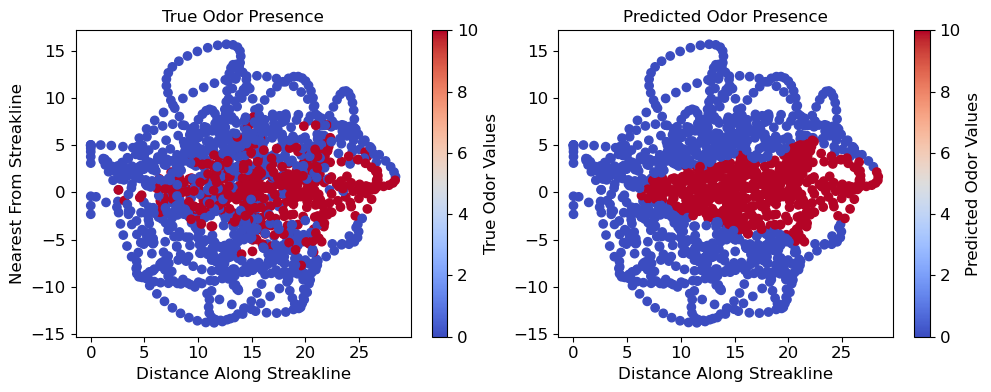

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Testing phase
test_file_path = "/home/beast/An/data/Sept13Plumes/plume1/train/diag39.h5"
test_df = pd.read_hdf(test_file_path)

gp = trained_models[test_file_path]
scaler = scalers[test_file_path]  # Retrieve the scaler for this model

if 'odor_binary' not in test_df.columns:
    test_df['odor_binary'] = test_df['odor'].apply(lambda x: 10 if x > 0 else 0)

# Scale the test data using the scaler
X_test_scaled = scaler.transform(test_df[['distance_along_streakline', 'nearest_from_streakline']])

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_true = test_df['odor_binary'].values

# GP in eval mode
gp.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = gp(X_test_tensor)
    y_pred_mean = observed_pred.mean.cpu().numpy()
    y_pred_std = observed_pred.stddev.cpu().numpy()

y_pred_binary = np.where(y_pred_mean > 4, 10, 0)

accuracy = accuracy_score(y_true, y_pred_binary)
report = classification_report(y_true, y_pred_binary)
print(f"Accuracy: {accuracy}")


f, axes = plt.subplots(1,2, figsize=(10, 4))

sc1 = axes[0].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=test_df['odor_binary'], cmap='coolwarm')
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('True Odor Values')
axes[0].set_title('True Odor Presence')
axes[0].set_xlabel('Distance Along Streakline')
axes[0].set_ylabel('Nearest From Streakline')


sc2 = axes[1].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=y_pred_binary, cmap='coolwarm')
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Predicted Odor Values')
axes[1].set_title('Predicted Odor Presence')
axes[1].set_xlabel('Distance Along Streakline')
# axes[1].set_ylabel('Nearest From Streakline')

f.tight_layout()

mpl_functions.set_fontsize(f, 12)


#### Test on files it has not seen but same plume

Accuracy: 0.8112


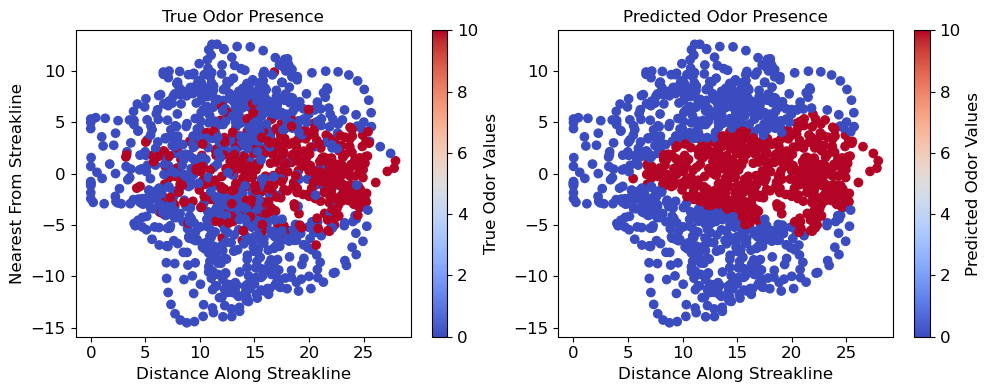

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

representative_file_path = "/home/beast/An/data/Sept13Plumes/plume1/train/diag39.h5"
gp_representative = trained_models[representative_file_path].to(device)
scaler = scalers[representative_file_path]  # Retrieve the scaler for this model

test_file_path = "/home/beast/An/data/Sept13Plumes/plume1/diag10.h5"
test_df = pd.read_hdf(test_file_path)

if 'odor_binary' not in test_df.columns:
    test_df['odor_binary'] = test_df['odor'].apply(lambda x: 10 if x > 0 else 0)

X_test_scaled = scaler.transform(test_df[['distance_along_streakline', 'nearest_from_streakline']])

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_true = test_df['odor_binary'].values

# Predict using the GP model
gp_representative.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = gp_representative(X_test_tensor)
    y_pred_mean = observed_pred.mean.cpu().numpy()

y_pred_binary = np.where(y_pred_mean > 4, 10, 0)

accuracy = accuracy_score(y_true, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Visualization
f, axes = plt.subplots(1, 2, figsize=(10, 4))
sc1 = axes[0].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], c=test_df['odor_binary'], cmap='coolwarm')
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('True Odor Values')
axes[0].set_title('True Odor Presence')
axes[0].set_xlabel('Distance Along Streakline')
axes[0].set_ylabel('Nearest From Streakline')

sc2 = axes[1].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], c=y_pred_binary, cmap='coolwarm')
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Predicted Odor Values')
axes[1].set_title('Predicted Odor Presence')
axes[1].set_xlabel('Distance Along Streakline')

f.tight_layout()
mpl_functions.set_fontsize(f, 12)